<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

#cGAN tutorial
Code based on https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# TL;DR

1. In this lab scenario you will train your own cGAN model on a MNIST dataset i.e. a network generating a selected fake hand-written digit.
2. You will learn how to train the network using the adversarial objective and the "log-D" trick.
3. Finally you will understand how the generator works by performing an interpolation between two randomly generated images.

# Problem definition

The objective is to train a neural network that accepts a fixed-size random tensor and a class label as an input and outputs a counterfeit hand-written image mimicking MNIST datapoints.  


#  cGAN architecture
We will train an network based on [cGAN](https://arxiv.org/pdf/1411.1784.pdf) and [DCGAN](https://arxiv.org/abs/1511.06434).

The network consists of two parts:
* Discriminator, which accepts a datapoint (real or fake)
$x$ as well as a class label $y$ as an input and outputs the conditional probability $D(x|y)$ of the input image being a real image of class $y$.
* Generator, which accepts z fixed-size sample from the gaussian distribution $z$ as well as a random class label $y$ as an input and outputs a sample from the conditional distribution $G(z|y)$.

![](https://drive.google.com/uc?export=view&id=12qRdmfkO-dvapBVwoZjOpLVd_OdJdvtQ)

Image source: https://arxiv.org/pdf/1411.1784.pdf

cGAN is trained using the adversarial objective:
1. In the first step weights of the Discriminator are trained similarly to a binary classification:
    1. A batch of real images with corresponding class labels and training objective (1 meaning <b>REAL</b> image) is prepared and put through the Discriminator. The real loss is calculated.
    2. A batch of samples from the gaussian distribution with sample of fake labels amd training objective (0 meaning <b> FAKE </b> image) is prepared and put through the Generator and then the Discriminator. The fake loss is calculated.
    3. The final loss is calculated as the average between the real loss and the fake loss and used for training of the Discriminator parameters.
2. In the second step weights of the Generator are trained using the ["log-D" trick](https://arxiv.org/pdf/2009.00169v1.pdf):
    1. A batch of samples from the gaussian distribution with sample of fake labels and training objective (1 meaning <b> FAKE REAL </b> image) is prepared and put through the Generator and then the Discriminator. The fake real loss is calculated.
    2. The fake real loss used for training of the Generator parameters.

Some technical remarks:
1. Image class labels are inserted as 1-dimentional tensors (with integers 0-9) and passed through the [Pytorch Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) to construct embeddings.
2. Image class embeddings are concatenated with images / samples from the gaussian distribution channelwise.
3. In the first step of adversarial training half of the batch are real images and half of the batch are fake images.


# Tasks

1. Read the code.
2. Run the pipeline, verify that:
    1. The generator creates decent counterfeit images.
    2. The quality of generated images improves over time.

3. Modify the code to perform interpolation between two sample images of the same class:
    1. Use the generator to obtain two images based on two sample tensors
$z_1, z_2$.
    2. Generate a sequence of images based on the segment with endpoints
$z_1, z_2$.
    3. Visualize the "transiton" of the sequence.

4. Modify the code to check how the "transition" between two samples change over the training time.



In [1]:
# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
nz = 98

# Number of training epochs
num_epochs = 10

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms # type: ignore
import torchvision.utils as vutils # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from torch.utils.data import DataLoader

import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import MNIST # type: ignore

torch.manual_seed(0)
np.random.seed(0)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)
dataset = MNIST(os.getcwd(), transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 94713691.04it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13692290.47it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26615961.35it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [4]:
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

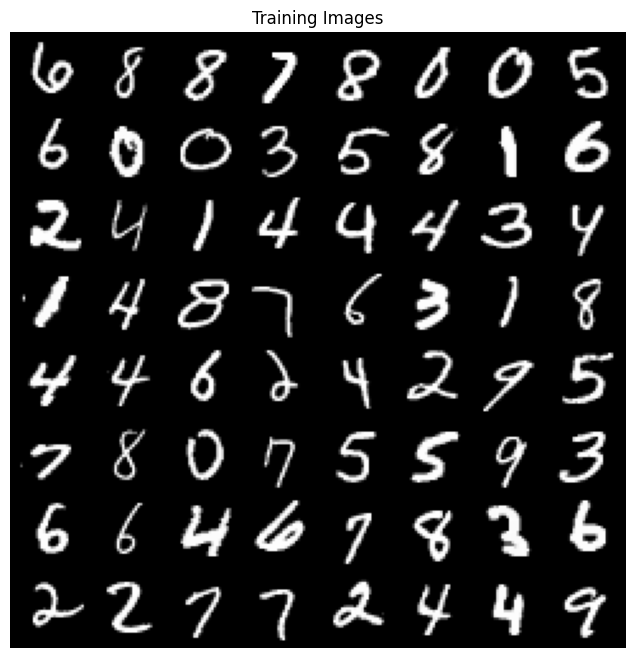

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

In [6]:
# sanity check: look at dataset basic statistics
print(
    real_batch[0].size(),
    real_batch[0].min(),
    real_batch[0].max(),
    real_batch[1].min(),
    real_batch[1].max(),
    real_batch[1].size(),
)

torch.Size([128, 1, 28, 28]) tensor(-1.) tensor(1.) tensor(0) tensor(9) torch.Size([128])


In [7]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(10, 49)
        self.linear = nn.Linear(49, 49)
        self.upconvolutions = nn.Sequential(
            nn.ConvTranspose2d(
                nz // 49 + 1,
                64,
                5,
                2,
                0,
                bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                64,
                32,
                4,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                32,
                4,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                4,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                16,
                3,
                1,
                0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
        )
        self.convolutions = nn.Sequential(
            nn.Conv2d(
                16,
                16,
                kernel_size=(3, 3),
                padding=1,
                stride=1,
                bias=False,),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                16,
                1,
                kernel_size=(3, 3),
                padding=1,
                stride=1,
                bias=False,),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y = self.embedding(y).squeeze()
        y = self.linear(y)
        y = F.relu(y)

        x = x.view(-1, nz // 49, 7, 7)
        y = y.view(-1, 1, 7, 7)

        x = torch.cat([x, y], dim=1)
        x = self.upconvolutions(x)
        x = self.convolutions(x)
        return x

In [8]:
# Create the generator
netG = Generator().to(device)

# Print the model
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_y = torch.randint(0, 10, (64, 1), device=device)
print(netG(fixed_noise, fixed_y).size())

torch.Size([64, 1, 28, 28])


In [9]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(10, 49)
        self.linear = nn.Linear(49, 28 * 28)
        self.convolutions = nn.Sequential(
        nn.Conv2d(
            2,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(
            64,
            128,
            kernel_size=(7, 7),
            padding=0,
            stride=1,
            bias=False,),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        )

        self.output = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y = self.embedding(y).squeeze()
        y = self.linear(y)
        y = F.leaky_relu(y)
        y = y.view([-1, 1, 28, 28])

        x = torch.cat([x, y], dim=1)
        x = self.convolutions(x)
        x = x.view(-1, 128)
        x = self.output(x)

        return x

In [10]:
# Create the Discriminator
netD = Discriminator().to(device)

# Print the model
print(netD)

Discriminator(
  (embedding): Embedding(10, 49)
  (linear): Linear(in_features=49, out_features=784, bias=True)
  (convolutions): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): 

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_y = torch.randint(0, 10, (64, 1), device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")
    for i, data in pbar:

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        optimizerG.zero_grad()
        optimizerD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        real_y = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, real_y).view(-1)
        D_x = output.mean().item()
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise_y = torch.randint(0, 10, (b_size, 1), device=device)
        # Generate fake image batch with G
        fake = netG(noise, noise_y)
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        output = netD(fake.detach(), noise_y.detach()).view(-1)
        D_G_z1 = output.mean().item()
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Add the gradients from the all-real and all-fake batches
        errD = (errD_real + errD_fake) / 2
        # Calculate the gradients for this batch
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerD.zero_grad()
        optimizerG.zero_grad()

        noise = torch.randn(2 * b_size, nz, 1, 1, device=device)
        noise_y = torch.randint(0, 10, (2 * b_size, 1), device=device)
        fake = netG(noise, noise_y)
        label = torch.full((2 * b_size,), real_label, dtype=torch.float, device=device)

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, noise_y).view(-1)
        D_G_z2 = output.mean().item()
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 250 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or (i == len(dataloader) - 1):
            netG.eval()
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_y).detach().cpu()

            netG.train()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


Epoch 0:   1%|          | 3/469 [00:01<02:28,  3.14it/s]

[0/10][0/469]	Loss_D: 0.7111	Loss_G: 0.7788	D(x): 0.4611	D(G(z)): 0.4611 / 0.4641


Epoch 0:  54%|█████▍    | 253/469 [00:15<00:11, 18.09it/s]

[0/10][250/469]	Loss_D: 0.5018	Loss_G: 1.0864	D(x): 0.6315	D(G(z)): 0.4044 / 0.3451


Epoch 1:   1%|          | 3/469 [00:00<00:35, 12.97it/s]

[1/10][0/469]	Loss_D: 0.4995	Loss_G: 0.9515	D(x): 0.5954	D(G(z)): 0.3675 / 0.3987


Epoch 1:  54%|█████▍    | 253/469 [00:14<00:12, 17.98it/s]

[1/10][250/469]	Loss_D: 0.4506	Loss_G: 1.1298	D(x): 0.6446	D(G(z)): 0.3473 / 0.3407


Epoch 2:   1%|          | 3/469 [00:00<00:35, 13.10it/s]

[2/10][0/469]	Loss_D: 0.4008	Loss_G: 1.3573	D(x): 0.7377	D(G(z)): 0.3637 / 0.2876


Epoch 2:  54%|█████▍    | 253/469 [00:15<00:12, 17.35it/s]

[2/10][250/469]	Loss_D: 0.3220	Loss_G: 1.5868	D(x): 0.7414	D(G(z)): 0.2662 / 0.2254


Epoch 3:   1%|          | 3/469 [00:00<00:37, 12.59it/s]

[3/10][0/469]	Loss_D: 0.3769	Loss_G: 1.5580	D(x): 0.7414	D(G(z)): 0.2885 / 0.2421


Epoch 3:  54%|█████▍    | 253/469 [00:17<00:14, 14.66it/s]

[3/10][250/469]	Loss_D: 0.3239	Loss_G: 2.1581	D(x): 0.7700	D(G(z)): 0.2758 / 0.1523


Epoch 4:   1%|          | 3/469 [00:00<00:36, 12.73it/s]

[4/10][0/469]	Loss_D: 0.3107	Loss_G: 1.5553	D(x): 0.8403	D(G(z)): 0.3189 / 0.2655


Epoch 4:  54%|█████▍    | 253/469 [00:15<00:12, 17.51it/s]

[4/10][250/469]	Loss_D: 0.2876	Loss_G: 1.7144	D(x): 0.7462	D(G(z)): 0.2041 / 0.2133


Epoch 5:   1%|          | 3/469 [00:00<00:37, 12.39it/s]

[5/10][0/469]	Loss_D: 0.2744	Loss_G: 2.1118	D(x): 0.7898	D(G(z)): 0.2253 / 0.1524


Epoch 5:  54%|█████▍    | 253/469 [00:15<00:12, 17.26it/s]

[5/10][250/469]	Loss_D: 0.2191	Loss_G: 2.0657	D(x): 0.8731	D(G(z)): 0.2365 / 0.1721


Epoch 6:   1%|          | 3/469 [00:00<00:37, 12.48it/s]

[6/10][0/469]	Loss_D: 0.2914	Loss_G: 2.1732	D(x): 0.7990	D(G(z)): 0.2436 / 0.1661


Epoch 6:  54%|█████▍    | 253/469 [00:15<00:12, 17.15it/s]

[6/10][250/469]	Loss_D: 0.1949	Loss_G: 2.6346	D(x): 0.8785	D(G(z)): 0.2084 / 0.0972


Epoch 7:   1%|          | 3/469 [00:00<00:37, 12.51it/s]

[7/10][0/469]	Loss_D: 0.2157	Loss_G: 2.1577	D(x): 0.7923	D(G(z)): 0.1459 / 0.1667


Epoch 7:  54%|█████▍    | 253/469 [00:15<00:12, 17.37it/s]

[7/10][250/469]	Loss_D: 0.2108	Loss_G: 2.3930	D(x): 0.7801	D(G(z)): 0.1249 / 0.1213


Epoch 8:   1%|          | 3/469 [00:00<00:36, 12.65it/s]

[8/10][0/469]	Loss_D: 0.2438	Loss_G: 2.2686	D(x): 0.7560	D(G(z)): 0.1448 / 0.1750


Epoch 8:  54%|█████▍    | 253/469 [00:15<00:12, 17.19it/s]

[8/10][250/469]	Loss_D: 0.1586	Loss_G: 2.0175	D(x): 0.8495	D(G(z)): 0.1217 / 0.1794


Epoch 9:   1%|          | 3/469 [00:00<00:37, 12.58it/s]

[9/10][0/469]	Loss_D: 0.2756	Loss_G: 2.7262	D(x): 0.8460	D(G(z)): 0.2638 / 0.1117


Epoch 9:  54%|█████▍    | 253/469 [00:15<00:12, 17.35it/s]

[9/10][250/469]	Loss_D: 0.1791	Loss_G: 2.9597	D(x): 0.8881	D(G(z)): 0.1872 / 0.0789


Epoch 9: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]


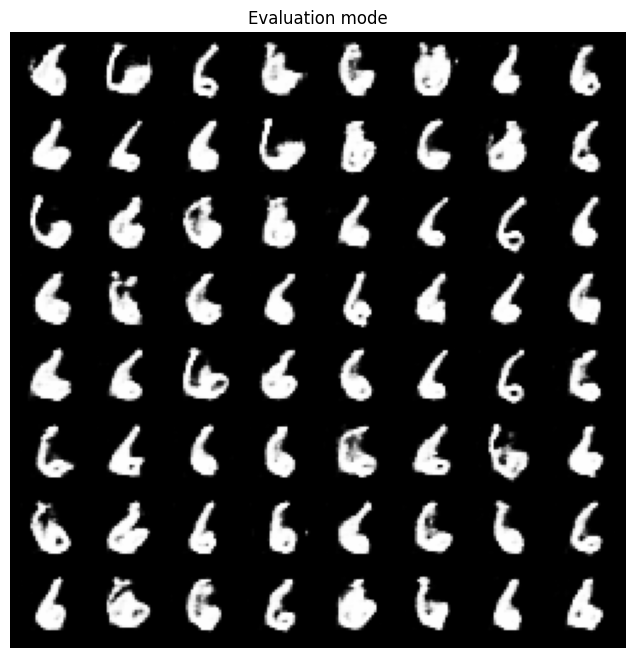

In [13]:
generated_label = 6

test_noise = torch.randn(64, nz, 1, 1, device=device)
test_y = torch.randint(generated_label, generated_label + 1, (64, 1), device=device)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Evaluation mode")
netG.zero_grad()
netG.eval()
plt.imshow(
    np.transpose(
        vutils.make_grid(
            netG(test_noise, test_y).detach().cpu(), padding=2, normalize=True
        ),
        (1, 2, 0),
    )
)

In [14]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# #########################################################
#                    To implement
# #########################################################
noise_1 = torch.randn(size=(1, nz)).to(device)
noise_2 = torch.randn(size=(1, nz)).to(device)
noise_y = torch.randint(0, 10, size=(1, 1)).to(device)

img_sequence = []

for t in np.arange(0, 1, 0.1):
  noise = (1-t)*noise_1 + t*noise_2
  img = netG(noise, noise_y)[0][0]
  img_sequence.append(img.detach().cpu().numpy())

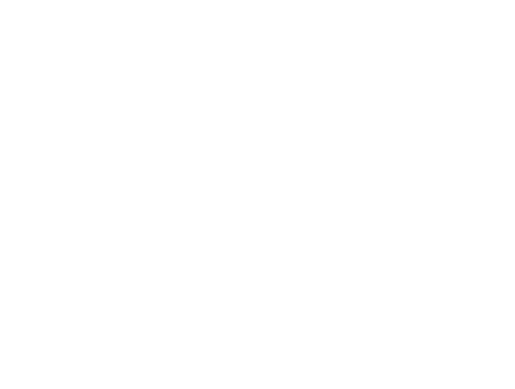

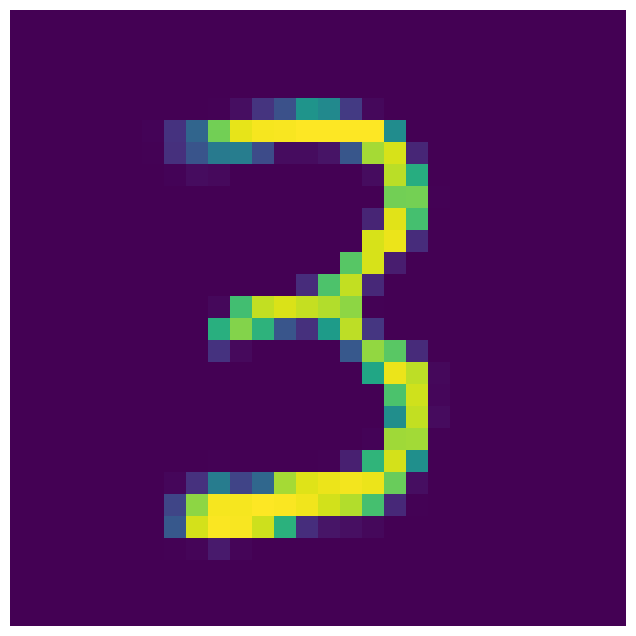

In [29]:
plt.axis("off")
fig_sequence = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_sequence]
ani = animation.ArtistAnimation(fig_sequence, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())